# Package loading and basic configurations

In [1]:
%load_ext autoreload
%autoreload 2

# load dependencies
import pandas as pd
import geopandas as gpd

from enpyrocar import TrackAPI, DownloadClient, BboxSelector, ECConfig

# create initial config and api client
config = ECConfig()
track_api = TrackAPI(api_client=DownloadClient(config=config))

# Querying enviroCar Tracks

The following cell queries tracks from the enviroCar API. It defines a bbox for the area of Münster (Germany) and requests 50 tracks. The result is a GeoDataFrame, which is a geo-extended Pandas dataframe from the GeoPandas library. It contains all information of the track in a flat dataframe format including a specific geometry column. 

In [2]:
bbox = BboxSelector([
    7.601165771484375, # min_x
    51.94807412325402, # min_y
    7.648200988769531, # max_x
    51.97261482608728  # max_y
])

# issue a query
track_df = track_api.get_tracks(bbox=bbox, num_results=50) # requesting 50 tracks inside the bbox
track_df

,id,time,geometry,Intake Pressure.value,Intake Pressure.unit,Throttle Position.value,Throttle Position.unit,Speed.value,Speed.unit,GPS Accuracy.value,...,sensor.id,sensor.fuelType,sensor.constructionYear,sensor.manufacturer,O2 Lambda Voltage ER.value,O2 Lambda Voltage ER.unit,MAF.value,MAF.unit,O2 Lambda Voltage.value,O2 Lambda Voltage.unit
0,5e42ccb63965f3689459b873,2020-02-03T17:11:48,POINT (7.65632 51.93630),32.884553,kPa,14.000000,%,0.000000,km/h,6.000000,...,5de3dba044ea85025c07072e,gasoline,2019,Ford,NaN,NaN,NaN,NaN,NaN,NaN
1,5e42ccb63965f3689459b875,2020-02-03T17:11:53,POINT (7.65632 51.93630),32.698209,kPa,14.000000,%,0.000000,km/h,6.000000,...,5de3dba044ea85025c07072e,gasoline,2019,Ford,NaN,NaN,NaN,NaN,NaN,NaN
2,5e42ccb63965f3689459b876,2020-02-03T17:11:58,POINT (7.65632 51.93630),32.000000,kPa,14.000000,%,0.000000,km/h,6.000000,...,5de3dba044ea85025c07072e,gasoline,2019,Ford,NaN,NaN,NaN,NaN,NaN,NaN
3,5e42ccb63965f3689459b877,2020-02-03T17:12:03,POINT (7.65634 51.93631),86.869563,kPa,27.571429,%,4.133705,km/h,8.000000,...,5de3dba044ea85025c07072e,gasoline,2019,Ford,NaN,NaN,NaN,NaN,NaN,NaN
4,5e42ccb63965f3689459b878,2020-02-03T17:12:08,POINT (7.65660 51.93645),35.941521,kPa,16.431345,%,22.999999,km/h,4.951049,...,5de3dba044ea85025c07072e,gasoline,2019,Ford,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,5dc9c2ff44ea856b7034cc34,2019-10-25T07:27:20,POINT (7.65398 51.93818),41.505696,kPa,17.265910,%,58.000001,km/h,1.545671,...,559e22c2e4b07207d8977998,gasoline,2004,Mercedes Benz,NaN,NaN,NaN,NaN,NaN,NaN
126,5dc9c2ff44ea856b7034cc35,2019-10-25T07:27:26,POINT (7.65478 51.93765),28.596639,kPa,15.449865,%,57.000000,km/h,3.000000,...,559e22c2e4b07207d8977998,gasoline,2004,Mercedes Benz,NaN,NaN,NaN,NaN,NaN,NaN
127,5dc9c2ff44ea856b7034cc36,2019-10-25T07:27:31,POINT (7.65554 51.93712),32.000000,kPa,16.000000,%,55.406485,km/h,1.922577,...,559e22c2e4b07207d8977998,gasoline,2004,Mercedes Benz,NaN,NaN,NaN,NaN,NaN,NaN
128,5dc9c2ff44ea856b7034cc37,2019-10-25T07:27:36,POINT (7.65623 51.93664),29.999999,kPa,13.000000,%,40.965938,km/h,3.000000,...,559e22c2e4b07207d8977998,gasoline,2004,Mercedes Benz,NaN,NaN,NaN,NaN,NaN,NaN


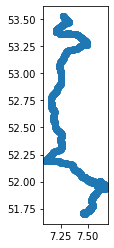

In [3]:
track_df.plot()

# Example: Visualization with pydeck (deck.gl)

The pydeck library makes use of the basemap tiles from Mapbox. In case you want to visualize the map with basemap tiles, you need to register with MapBox, and configure a specific access token. The service is free until a certain level of traffic is esceeded.

You can either configure it via your terminal (i.e. `export MAPBOX_API_KEY=<mapbox-key-here>`), which pydeck will automatically read, or you can pass it as a variable to the generation of pydeck (i.e. `pdk.Deck(mapbox_key=<mapbox-key-here>, ...)`.

In [6]:
import pydeck as pdk

# for pydeck the attributes have to be flat
track_df['lat'] = track_df['geometry'].apply(lambda coord: coord.y)
track_df['lng'] = track_df['geometry'].apply(lambda coord: coord.x)
vis_df = pd.DataFrame(track_df)
vis_df['speed'] = vis_df['Speed.value']

layer = pdk.Layer(
    'ScatterplotLayer',
    data=vis_df,
    get_position='[lng, lat]',
    auto_highlight=True,
    get_radius=10,          # Radius is given in meters
    get_fill_color='[speed < 30 ? 0 : (speed - 30)*3, speed < 30 ? speed * 4 : 255 - (speed-30)*3, 0, 140]',  # Set an RGBA value for fill
    pickable=True
)

# Set the viewport location
view_state = pdk.ViewState(
    longitude=7.5963592529296875,
    latitude=51.96246168188569,
    zoom=10,
    min_zoom=5,
    max_zoom=15,
    pitch=40.5,
    bearing=-27.36)

r = pdk.Deck(
    width=200, 
    layers=[layer], 
    initial_view_state=view_state #, mapbox_key=<mapbox-key-here>
)
r.to_html('tracks_muenster.html', iframe_width=900)

'/home/hafenkran/dev/envirocar/enpyrocar/examples/tracks_muenster.html'